# The importance of mode sources in integrated photonics simulations.
In this tutorial, we will investigate a straight waveguide, using a silicon ridge waveguide on a silicon oxide substrate.

## The codes are from 
### 1. FDTD Tutorial
### 2. Tidy3D Python interface/Sources/Defining mode sources and monitors.


In [1]:
# standard python imports
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl


import tidy3d as td
from tidy3d.plugins.mode import ModeSolver
from tidy3d import web

In [2]:
# Unit length is micron.
wg_height = 0.25
wg_width = 0.5

# Permittivity of waveguide and substrate
si_eps = 3.48**2
sio_eps = 1.45**2

# Free-space wavelength (in um) and frequency (in Hz)
lambda0 = 1.55
freq0 = td.C_0/lambda0
fwidth = freq0/10

# Simulation size inside the PML along propagation direction 
sim_length = 20 #um

# space between waveguide and PML
spacing = 1.5 #um

# Simulation domain size and total run time
sim_size = [sim_length, wg_width + spacing * 2, wg_height + spacing * 2]
run_time = 20/fwidth

# Grid specification
grid_spec = td.GridSpec.auto(min_steps_per_wvl=20, wavelength=lambda0)


In [3]:
# Define the substrate and the waveguide. The waveguide is oriented along the x-axis, and the mode is injected along the positive x-axis.
#! Note that they both need to be extended into the PML layers.
#? So, it is best to extend the substrate and waveguide beyond the simulation domain size.


mat_wg = td.Medium(permittivity=si_eps, name='silicon')
mat_sub = td.Medium(permittivity=sio_eps, name='silica')

#! Substrate
substrate = td.Structure(
    geometry=td.Box(
        center=[0, 0, -sim_size[2]],
        size = [td.inf, td.inf, 2*sim_size[2]-wg_height], #! The actual size of the substrate is 3 um, but we extend it into the PML layers.
    ),
    medium = mat_sub,
    name = 'substrate',
)
#! Waveguide
waveguide = td.Structure(
    geometry=td.Box(
        center=[0,0,0,],
        size=[td.inf, wg_width, wg_height], #! Infinitely long waveguide but does not matter. Only care about the simulation length.
    ),
    medium=mat_wg,
    name='waveguide',
)


In [4]:
# Define the monitors

# Modal source position (x coordinate)
src_pos = -sim_size[0]/2 + spacing

# monitor and modal plane size
sz_plane = 2 #um

mnt_list = []

#! xy-plane frequency-domain field monitor at central frequency
freq_mnt = td.FieldMonitor(
    center = [0, 0, 0],  #! Same as the center of the waveguide.
    size = [np.inf, np.inf, 0],
    freqs=[freq0],
    name='field')
mnt_list.append(freq_mnt)

#! A series of flux monitors
offset_from_source = 0.05 # a space between the first monitor and the source

pos_start = src_pos + offset_from_source # define the position of the monitor
pos_end = sim_size[0]/2 - spacing
num = 100
pos_list = np.linspace(pos_start, pos_end, num)

for i in range(num):
    flux_mnt = td.FluxMonitor(
        center = [pos_list[i], 0 , 0],
        size = [0, sz_plane, sz_plane],
        freqs = [freq0],
        name = "flux" + str(i)
    )
    mnt_list.append(flux_mnt)


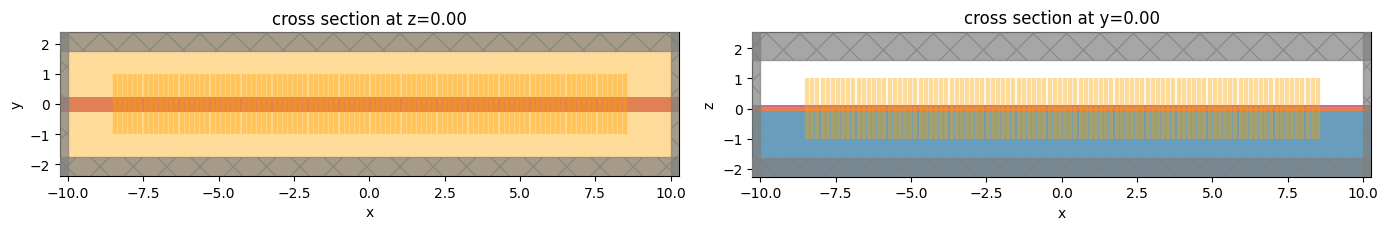

In [5]:
# Simulation
sim = td.Simulation(
    size=sim_size,
    grid_spec=grid_spec,
    structures=[substrate, waveguide],
    sources=[],
    monitors=mnt_list,
    run_time=run_time,
    boundary_spec=td.BoundarySpec.all_sides(boundary=td.PML())) #! Using PML boundary condition. Can be vary.

fig, (ax1, ax2) = plt.subplots(1, 2, tight_layout=True, figsize=(14, 5))
sim.plot(z=0, ax=ax1)
sim.plot(y=0, ax=ax2)
plt.show()

## Mode source
Before run a FDTD simulation with a mode source, we have to select which of the eigenmodes we would like to inject. Using eigenmode solver, we have to calculate the modes that decays at the infinity. 

In [6]:
# Setup the source
# src_plane = td.Box(center=[src_pos, 0, 0], size=[0, sz_plane, sz_plane])
src_plane = td.Box(center=[src_pos, 0, 0], size=[0, 2*sz_plane, 2*sz_plane])


# number of modes to compute
num_modes = 5

# setup and solve for modes
mode_spec = td.ModeSpec(num_modes=num_modes)
ms = ModeSolver(simulation=sim, plane=src_plane, mode_spec=mode_spec, freqs=[freq0])
modes = ms.solve()

print("Effective index of computed modes:", np.array(modes.n_eff))


10:06:38 중부 일광 절약 시간 WARNING: Use the remote mode solver with subpixel  
                             averaging for better accuracy through              
                             'tidy3d.plugins.mode.web.run(...)'.                

                     WARNING: Mode field at frequency index 0, mode index 2 does
                     not decay at the plane boundaries.                         

                     WARNING: Mode field at frequency index 0, mode index 3 does
                     not decay at the plane boundaries.                         

                     WARNING: Mode field at frequency index 0, mode index 4 does
                     not decay at the plane boundaries.                         

Effective index of computed modes: [[2.5667727 2.008351  1.4260856 1.4075884 1.3953216]]


wavelength     n eff  k eff  TE (Ey) fraction  \
f            mode_index                                                  
1.934145e+14 0                 1.55  2.566773    0.0          0.984804   
             1                 1.55  2.008351    0.0          0.047171   
             2                 1.55  1.426086    0.0          0.005232   
             3                 1.55  1.407588    0.0          0.990616   
             4                 1.55  1.395322    0.0          0.992183   

                         wg TE fraction  wg TM fraction  mode area  
f            mode_index                                             
1.934145e+14 0                 0.742881        0.840811   0.188724  
             1                 0.590646        0.893407   0.281221  
             2                 0.979217        0.983787   3.799950  
             3                 0.999119        0.922773   6.082341  
             4                 0.982974        0.952209   4.288685

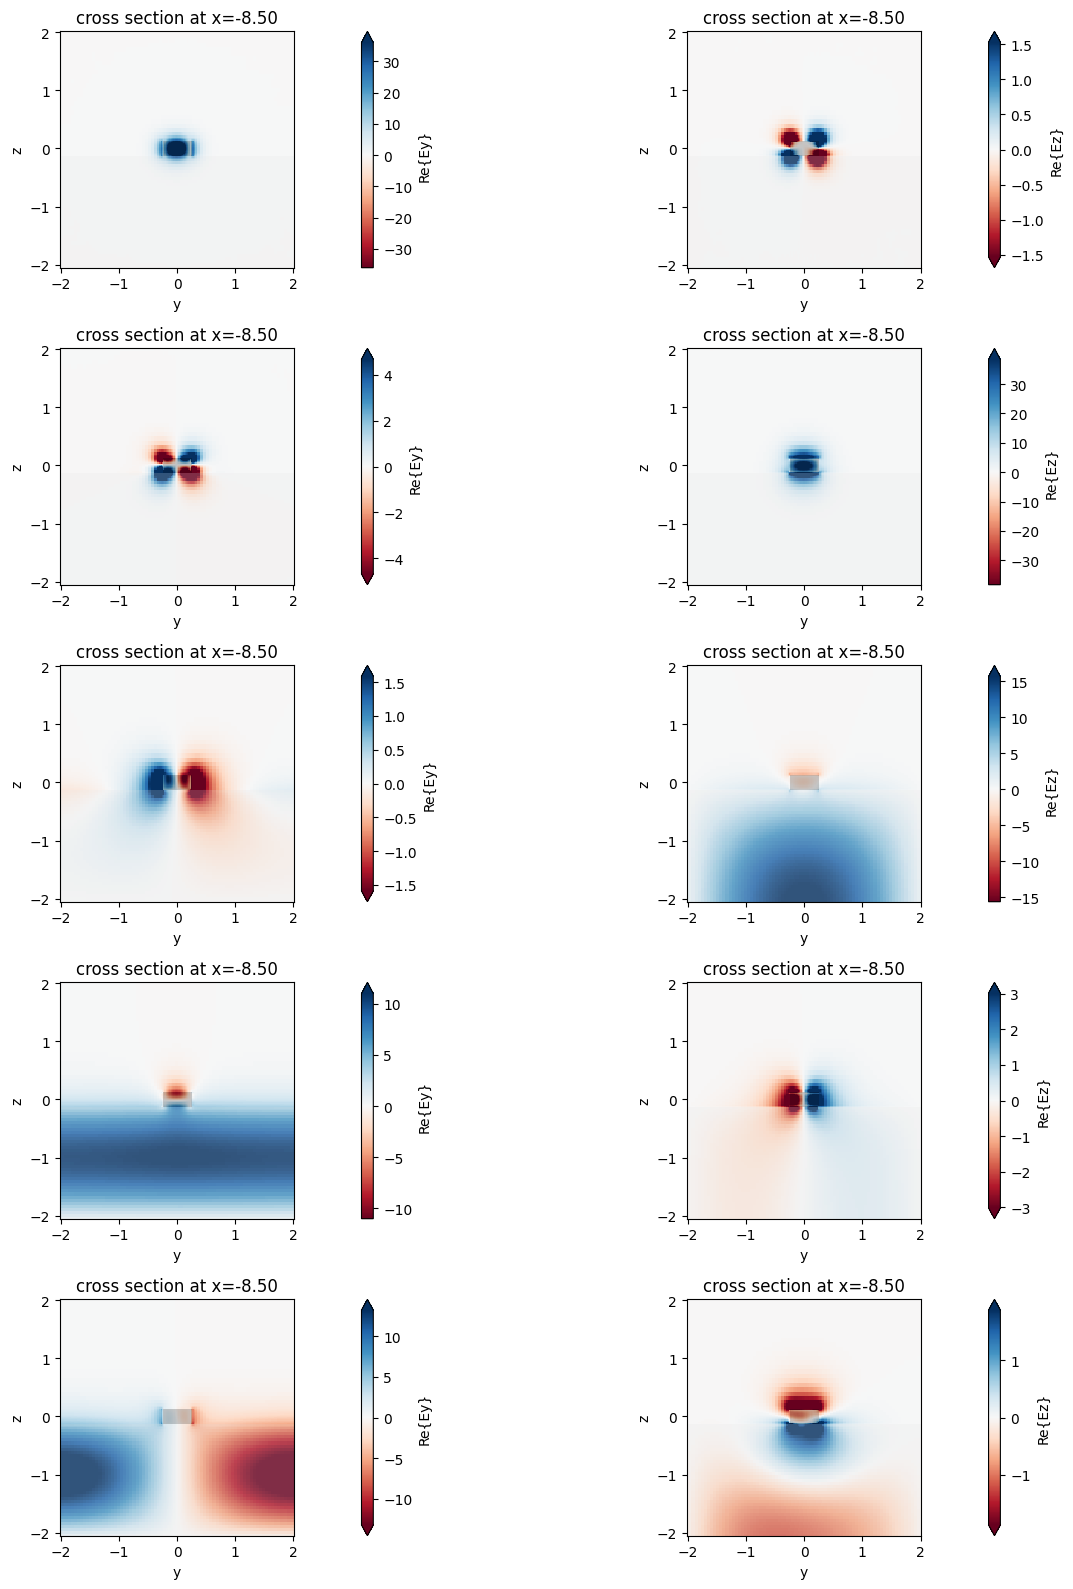

In [7]:
fig, axs = plt.subplots(num_modes, 2, figsize=(20, 16), tight_layout=True)
for mode_ind in range(num_modes):
    ms.plot_field("Ey", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 0])
    ms.plot_field("Ez", "real", f=freq0, mode_index=mode_ind, ax=axs[mode_ind, 1])
# plt.show()
modes.to_dataframe()

In [8]:
source_time = td.GaussianPulse(freq0=freq0, fwidth=fwidth)
mode_source = ms.to_source(mode_index=0, direction="+", source_time=source_time)  # change the mode index to excite different modes. 0 = fundamental TE mode.
sim = sim.copy(update={'sources':[mode_source]})

In [9]:
# This is just an example of the 

point_source = td.PointDipole(
    center=(src_pos, wg_width/4, wg_height/4),
    source_time=source_time,
    polarization='Ey',
    name='point source',
)
sim_point = sim.copy(update={'sources':[point_source]})

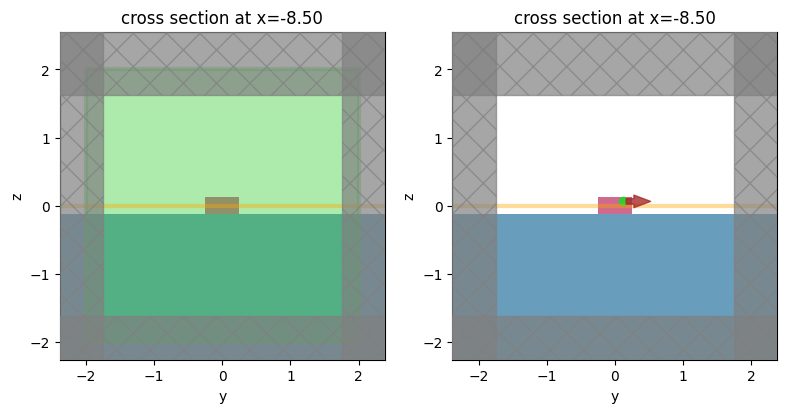

In [10]:
fig, ax = plt.subplots(1, 2, tight_layout=True, figsize=(8, 4))
sim.plot(x=src_pos, ax=ax[0]);
sim_point.plot(x=src_pos, ax=ax[1]);
plt.show()

In [11]:
sim_data = web.run(sim, task_name='lecture04_mode_source', path=f'data/Si_data_mode.hdf5')
sim_point_data = web.run(sim_point, task_name='lecture04_point_source', path=f'data/Si_data_point.hdf5')

10:07:05 중부 일광 절약 시간 Created task 'lecture04_mode_source' with task_id  
                             'fdve-09693b6e-203c-4ffe-9fa0-2964999432f2' and    
                             task_type 'FDTD'.

                     View task using web UI at                                  
                     ]8;id=464441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=493807;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\taskId]8;;\]8;id=464441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\=]8;;\]8;id=307078;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\fdve]8;;\]8;id=464441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\-0969]8;;\
                     ]8;id=464441;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\3b6e-203c-4ffe-9fa0-2964999432f2']8;;\.

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\rich\live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:07:13 중부 일광 절약 시간 status = queued

10:07:17 중부 일광 절약 시간 status = preprocess

10:07:24 중부 일광 절약 시간 You are running this simulation for FREE. Your     
                             current plan allows up to 20 free non-concurrent   
                             simulations per day (under 100.0M grid points and  
                             50.0K time steps)

                     starting up solver

                     running solver

                     To cancel the simulation, use 'web.abort(task_id)' or      
                     'web.delete(task_id)' or abort/delete the task in the web  
                     UI. Terminating the Python script will not stop the job    
                     running on the cloud.

10:07:48 중부 일광 절약 시간 early shutoff detected at 36%, exiting.

                     status = postprocess

10:08:04 중부 일광 절약 시간 status = success

                     View simulation result at                                  
                     ]8;id=787690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=416996;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\taskId]8;;\]8;id=787690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\=]8;;\]8;id=371482;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\fdve]8;;\]8;id=787690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\-0969]8;;\
                     ]8;id=787690;https://tidy3d.simulation.cloud/workbench?taskId=fdve-09693b6e-203c-4ffe-9fa0-2964999432f2\3b6e-203c-4ffe-9fa0-2964999432f2']8;;\.

10:08:08 중부 일광 절약 시간 loading simulation from data/Si_data_mode.hdf5

                     Created task 'lecture04_point_source' with task_id         
                     'fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2' and task_type  
                     'FDTD'.

                     View task using web UI at                                  
                     ]8;id=844660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\'https://tidy3d.simulation.cloud/workbench?]8;;\]8;id=549310;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\taskId]8;;\]8;id=844660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\=]8;;\]8;id=177796;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\fdve]8;;\]8;id=844660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\-e207]8;;\
                     ]8;id=844660;https://tidy3d.simulation.cloud/workbench?taskId=fdve-e207e48f-40cf-41a5-b1ba-83103d9698b2\e48f-40cf-41a5-b1ba-83103d9698b2']8;;\.

c:\Users\14087\Documents\GitHub\dft\.conda\lib\site-packages\rich\live.py:229: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

10:08:09 중부 일광 절약 시간 status = success

10:08:12 중부 일광 절약 시간 loading simulation from data/Si_data_point.hdf5

In [17]:
########################################################################################
#! Calculating the loss in waveguide. Only at the 1.55 um wavelength.
########################################################################################

flux_list = np.zeros_like(pos_list)
flux_point_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    flux_point_list[i] = sim_point_data['flux'+str(i)].flux

print("The loss is", -10*np.log10(flux_list[0]/flux_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0])*(10**(4)), "dB/cm")
print("The loss is", -10*np.log10(flux_point_list[0]/flux_point_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0])*(10**(4)), "dB/cm")
print("The length of the propagation of the waveguide is", (pos_list - src_pos)[-1] - (pos_list - src_pos)[0], "um")
print(flux_list[0]/flux_list[-1])
print(flux_point_list[0]/flux_point_list[-1])

The loss is 0.0050397876496364015 dB/cm
The loss is -1946.3276309602122 dB/cm
The length of the propagation of the waveguide is 16.95 um
0.9999980330324191
2.137482331132502


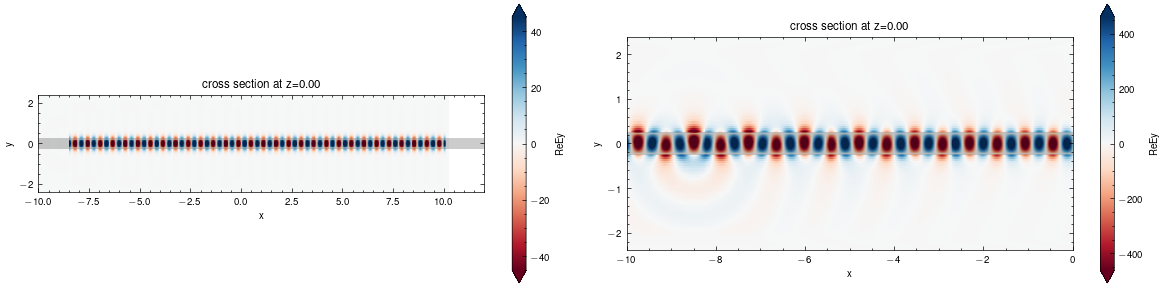

In [40]:
fig, ax = plt.subplots(1,2,figsize=(12, 3), tight_layout=True)

sim_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[0])
sim_point_data.plot_field('field', 'Ey', z=0, f=freq0, val='real', ax = ax[1])
ax[0].set_xlim([-10,12])

ax[1].set_xlim([-10,0])
plt.show()

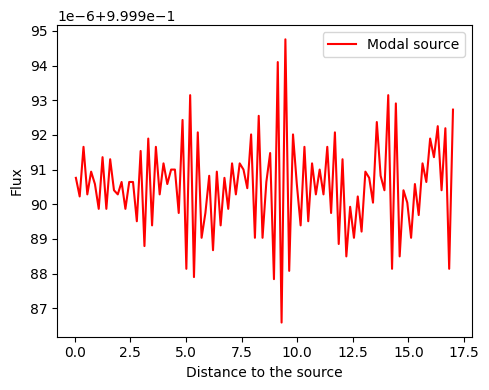

In [13]:
flux_list = np.zeros_like(pos_list)
# flux_point_list = np.zeros_like(pos_list)
for i in range(num):
    flux_list[i] = sim_data['flux'+str(i)].flux
    # flux_point_list[i] = sim_point_data['flux'+str(i)].flux

# TODO: Do this analysis in the spatial dependent dielectric permittivity case.
# normalize the dipole one
# flux_point_list /= flux_point_list[0]

fig, ax = plt.subplots(1,figsize=(5, 4), tight_layout=True)
ax.plot(pos_list - src_pos, flux_list, '-r',label='Modal source')
# ax.plot(pos_list - src_pos, flux_point_list, '--k', label='Point source')
ax.set_xlabel('Distance to the source')
ax.set_ylabel('Flux')
ax.legend()
ax.ylimit = [0, 1]
plt.show()

The loss is 5.039787649636402e-07 dB/um
The length of the waveguide is 16.95 um


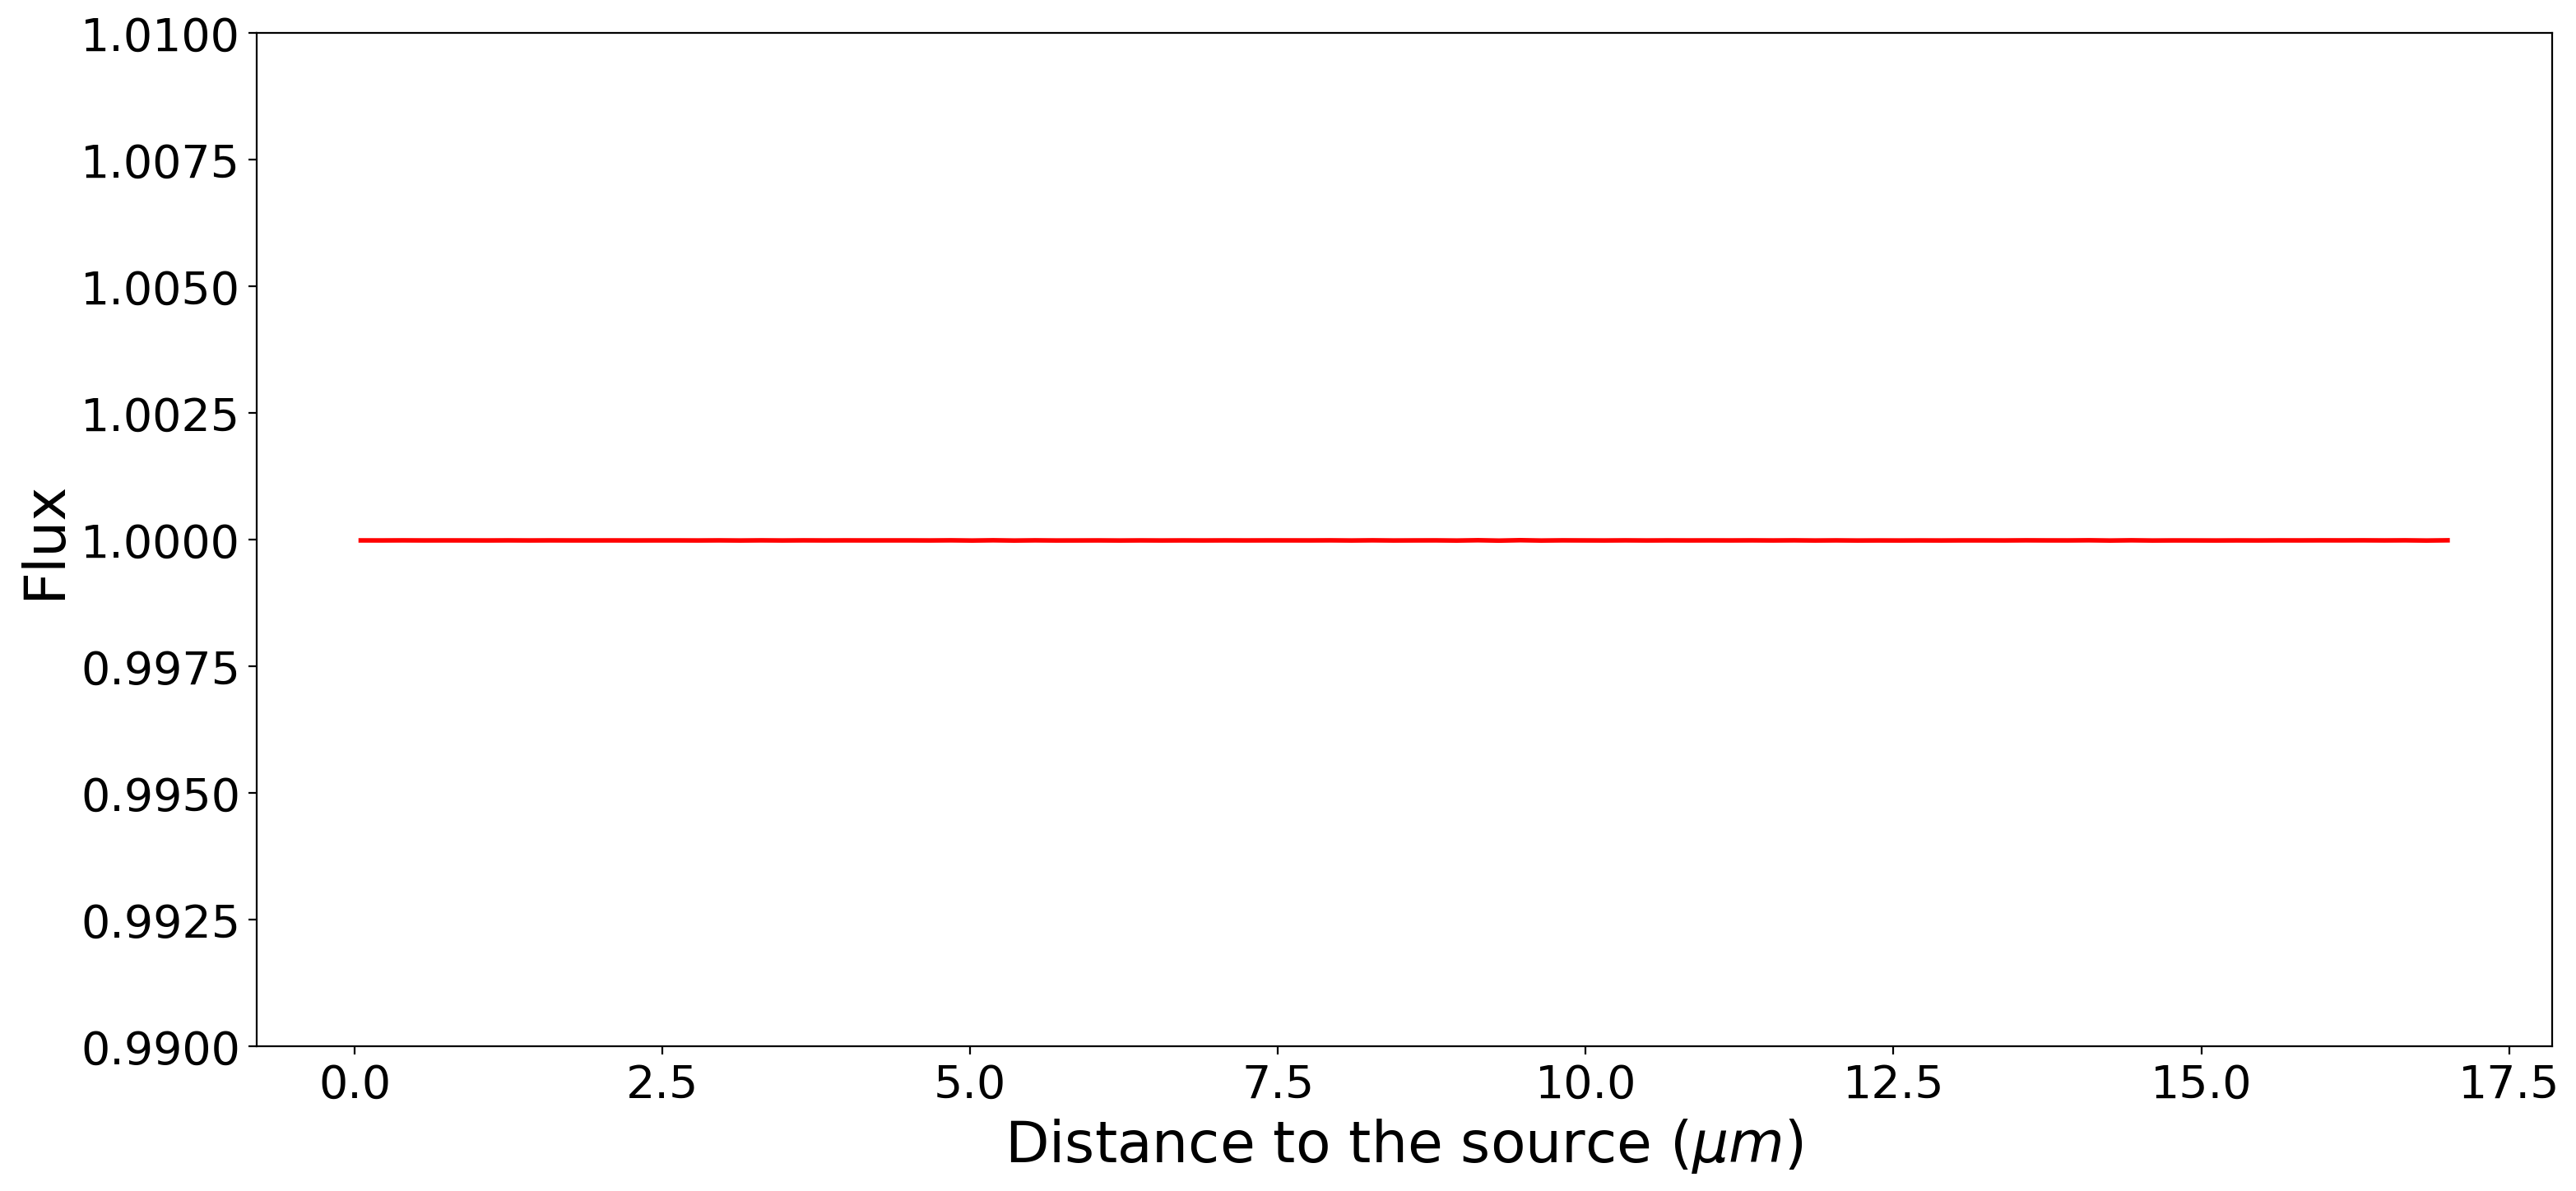

In [15]:
# import scienceplots

# plt.style.use(['science','nature'])

plt.figure(figsize=(18, 8), dpi=200)  
plt.plot(pos_list - src_pos, flux_list, '-r',label='Modal source', linewidth=2)
plt.ylim([0.99, 1.01])
plt.xlabel(r'Distance to the source $(\mu m)$', fontsize=25)
plt.tick_params(axis='both', which='major', labelsize=20)  # Increase tick number size
plt.ylabel('Flux', fontsize=25)
# plt.savefig('infi.png', dpi=200, format='png', bbox_inches='tight')  # Save the figure
print("The loss is", -10*np.log10(flux_list[0]/flux_list[-1])/((pos_list - src_pos)[-1] - (pos_list - src_pos)[0]), "dB/um")
print("The length of the waveguide is", (pos_list - src_pos)[-1] - (pos_list - src_pos)[0], "um")